In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In [2]:
def data_preprocessing(train_data, test_data):
    # Normalize data
    train_data_normalized = (train_data - train_data.mean()) / train_data.std()
    test_data_normalized = (test_data - test_data.mean()) / test_data.std()
    
    return train_data_normalized, test_data_normalized

In [3]:
train_data = pd.read_csv('/Users/hetvishukla/Deep learning/project/fashion MNIST/fashion-mnist_train.csv')
test_data =  pd.read_csv('/Users/hetvishukla/Deep learning/project/fashion MNIST/fashion-mnist_test.csv')


In [4]:
train_labels = train_data['label']
train_data.drop('label', axis=1, inplace=True)
test_labels = test_data['label']
test_data.drop('label', axis=1, inplace=True)

train_preprocess, test_preprocess = data_preprocessing(train_data, test_data)

combined_data = pd.concat([train_preprocess, train_preprocess], axis=0)

In [5]:
train_tensor = torch.tensor(train_data.values, dtype=torch.float32)
test_tensor =  torch.tensor(test_data.values, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values)
test_labels_tensor = torch.tensor(test_labels.values)

train_labels.describe()

print("Train images shape:", train_tensor.shape)
print("Train labels length:", len(train_labels_tensor))
print("Test images shape:", test_tensor.shape)
print("Test labels length:", len(test_labels_tensor))


# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# data_analysis(combined_data)

Train images shape: torch.Size([60000, 784])
Train labels length: 60000
Test images shape: torch.Size([10000, 784])
Test labels length: 10000


In [6]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x


In [7]:
def train_model_with_cv(model, criterion, optimizer, train_loader, test_loader, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_train_corrects = 0
        running_test_loss = 0.0
        running_test_corrects = 0
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            running_train_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        epoch_train_acc = running_train_corrects.double() / len(train_loader.dataset)
        train_accs.append(epoch_train_acc)

        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                running_test_corrects += torch.sum(preds == labels.data)

        epoch_test_loss = running_test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)
        epoch_test_acc = running_test_corrects.double() / len(test_loader.dataset)
        test_accs.append(epoch_test_acc)

        # print(f'Epoch [{epoch + 1}/{num_epochs}], '
        #       f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
        #       f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}')

    return train_losses, test_losses, train_accs, test_accs

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Activation function: relu


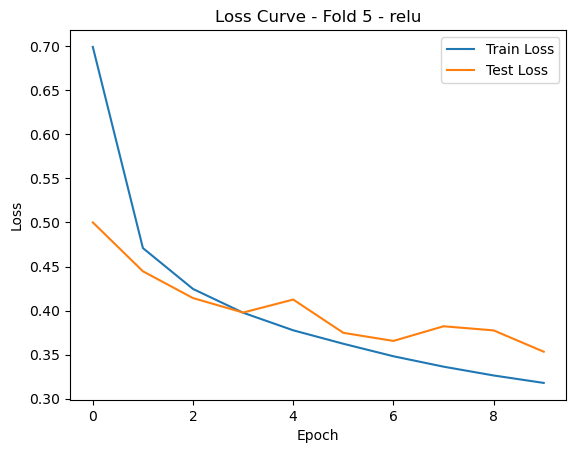

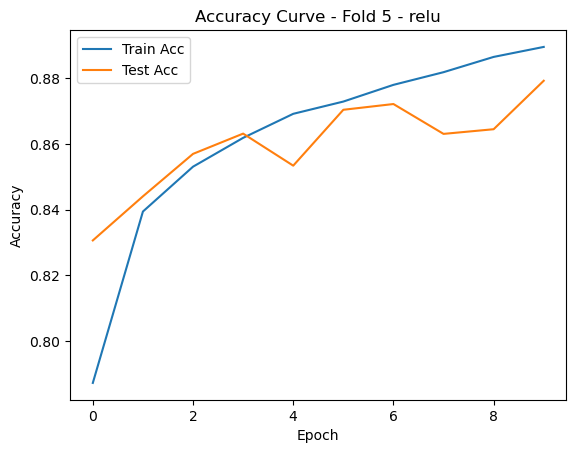

Activation function: sigmoid


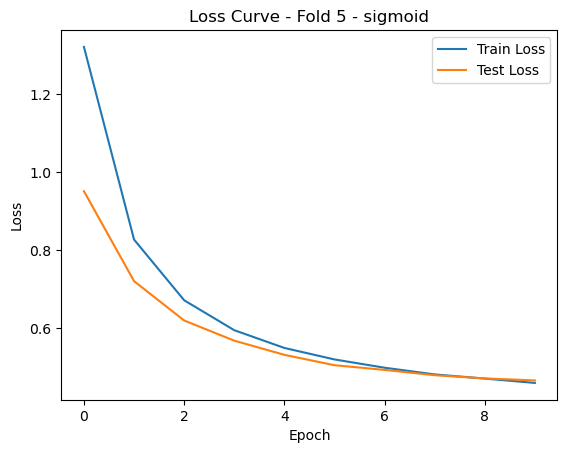

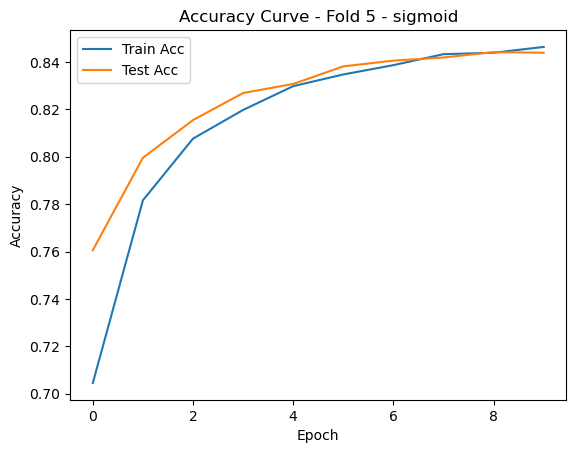

In [9]:
kf = KFold(n_splits=5, shuffle=True)

fold = 0
for train_index, test_index in kf.split(train_tensor):
    fold += 1
    print(f"Fold {fold}")
    train_data_fold, val_data_fold = train_tensor[train_index], train_tensor[test_index]
    train_labels_fold, val_labels_fold = train_labels_tensor[train_index], train_labels_tensor[test_index]

for activation in ['relu', 'sigmoid']:
    print(f"Activation function: {activation}")
    # Step 9: Initialize ANN model
    input_size = train_tensor.shape[1]
    hidden_size = 128
    num_classes = 10
    model = ANN(input_size, hidden_size, num_classes, activation)

    # Step 10: Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Step 11: Convert to DataLoader
    train_dataset = torch.utils.data.TensorDataset(train_data_fold, train_labels_fold)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataset = torch.utils.data.TensorDataset(val_data_fold, val_labels_fold)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Step 12: Train the model with k-fold cross-validation
    train_losses, test_losses, train_accs, test_accs = train_model_with_cv(model, criterion, optimizer,
                                                                         train_loader, val_loader, num_epochs=10)

    # Step 13: Plot loss and accuracy curves
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - Fold {fold} - {activation}')
    plt.legend()
    plt.show()

    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - Fold {fold} - {activation}')
    plt.legend()
    plt.show()